<h1> Accident Detection From CCTV Footage </h1>

In [41]:
!nvidia-smi

Wed Apr 16 20:56:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660      WDDM  |   00000000:01:00.0  On |                  N/A |
| 41%   34C    P8             20W /  130W |    1252MiB /   6144MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

<h2>Description :</h2>
<h3>Dataset Description :</h3>
<p> Accident Detection dataset collected from the CCTV footages containing a total of 990 accident and non-accident frames collected from road videos available on YouTube. The 990 files are split in the 791 training frames, 101 test frames and 98 validation frames.
791 (369-accident, 492-non accident) Training, 101 Test and 98 Validation (52-accident, 46-non accident) frames split in Accident and Non-accident frames in all the three folders. </p>

<h3>Problem Analysis: </h3>
<pre>
Input : Images that can be accident/Non Accident
Output : 0(Indicates No Accident)
         1(Indicates Accident)
</pre>

<h1>1. Loading Data</h1>

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [44]:
tr_data_dir = os.path.join("./data/train")
tr_data = tf.keras.utils.image_dataset_from_directory(
                            tr_data_dir,image_size=(256, 256),
                            seed = 12332
                            ) 
# here we resize image to 256*256
# We randomly shuffled data with seed
# we will do automatic feature extraction later usiing filtering and pooling layers

Found 1391 files belonging to 2 classes.


In [45]:
# We can't access this data directly by data[0] ; this will give us an error
# We have to get an iterator for this & call iterator to get each batch of 32  images 

tr_data_iterator = tr_data.as_numpy_iterator()
tr_batch = tr_data_iterator.next()



In [46]:
len(tr_batch[0]) # this gives Num of Images in training Batch

32

<h2>2.Dataset visualisation </h2>

In [47]:
def label_to_category(label):
    if(label == 1):
        return "No Accident"
    elif label == 0:
        return "Accident"
    else :
        return "error"

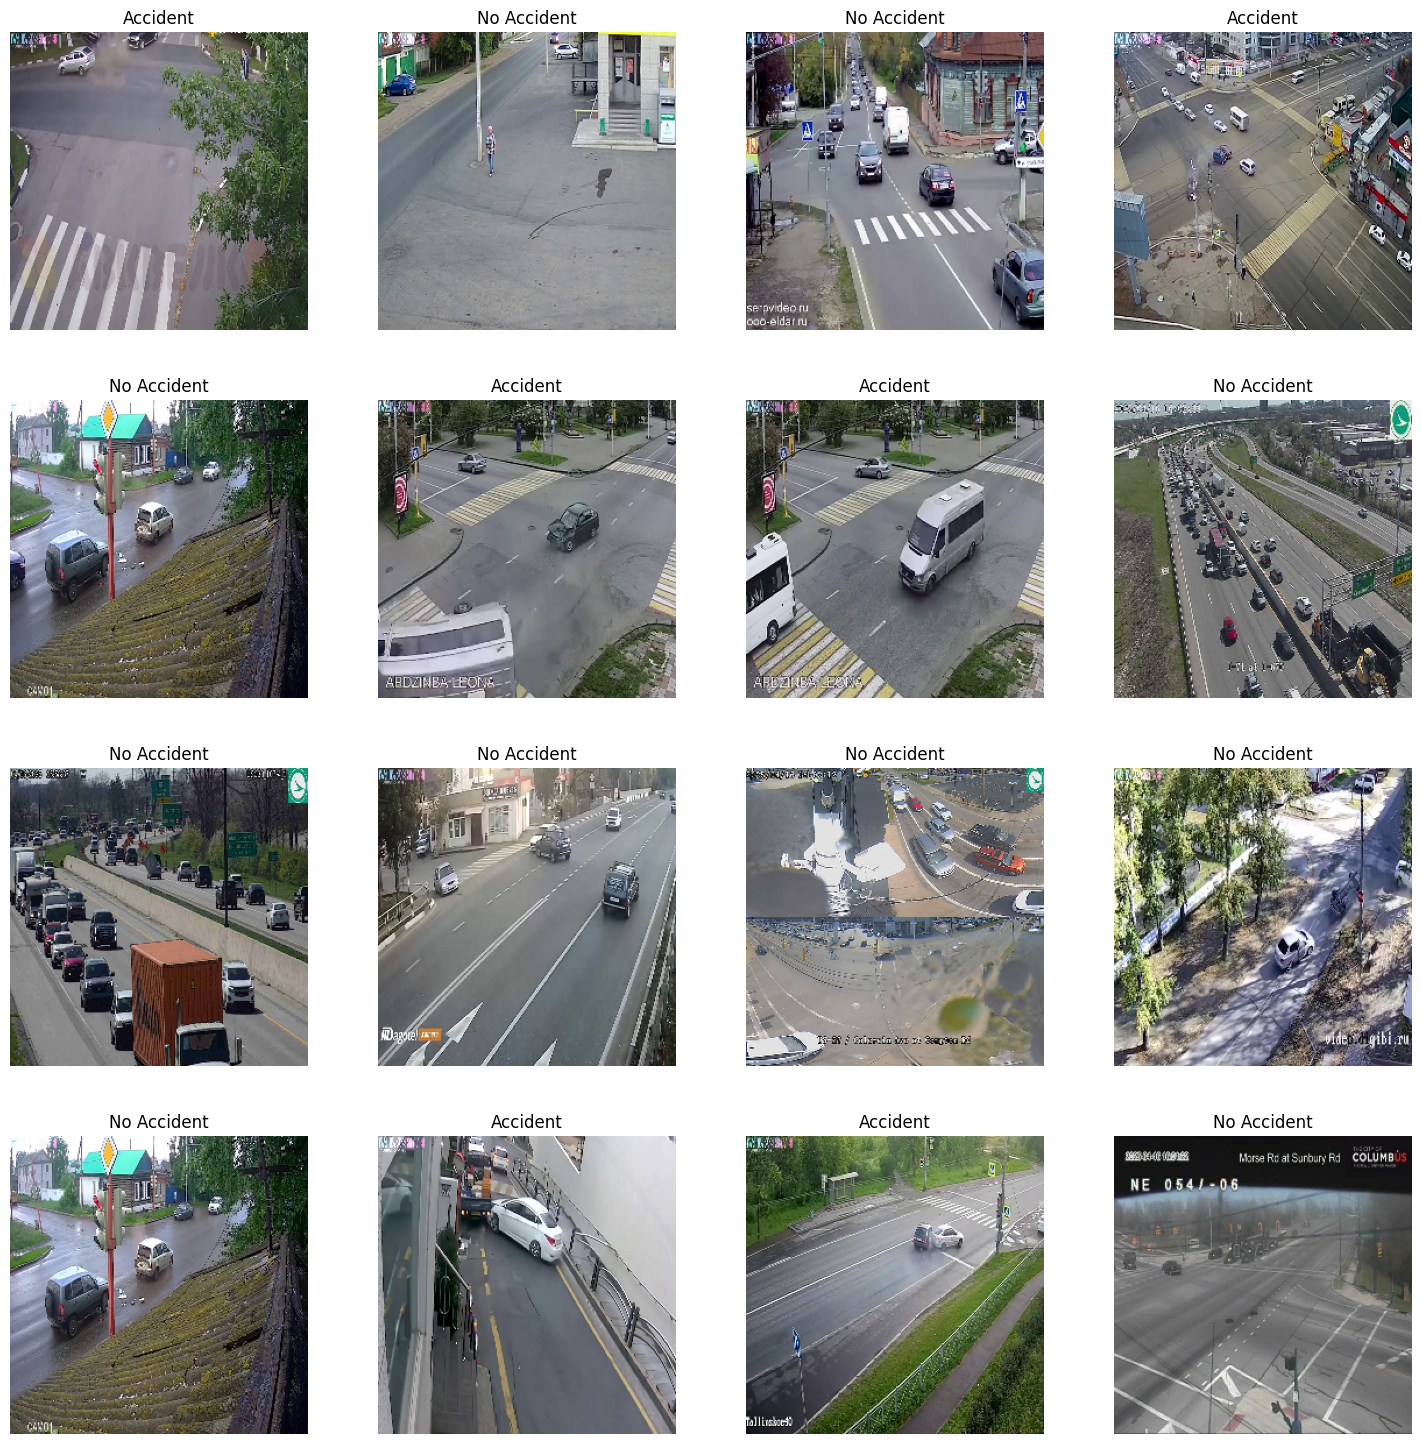

In [48]:
#Plotting full batch of 32 images together

cols = 4 
rows = 4
fig, ax = plt.subplots(nrows= rows , ncols= cols,figsize=(15,15),layout='constrained')
fig.tight_layout(pad=2)




for outer_index, img in enumerate(tr_batch[0][:]):
    if outer_index >= rows*cols:
        break
        
    if (outer_index % cols == 0):
        for inner_index, img in enumerate(tr_batch[0][outer_index:outer_index+cols]):
    
        
            ax[outer_index//cols][inner_index].imshow(img.astype(int))

            label = label_to_category(tr_batch[1][outer_index + inner_index])        
    
            
            ax[outer_index//cols][inner_index].set_aspect(1)

            num_label = tr_batch[1][outer_index + inner_index]
            
            ax[outer_index//cols][inner_index].axis("off")
            ax[outer_index//cols][inner_index].title.set_text(label)
            

plt.savefig("test.png")       
plt.show()




<h1>2. Preprocessing Data </h1>

In [49]:
# Normalizing pixels value between between 0 & 1 
tr_data = tr_data.map(lambda x,y: (x/255, y))


In [50]:
tr_batch = tr_data.as_numpy_iterator().next()

In [51]:
# Checking pixel min/max pixel values after normalization
print("Max pixel value : ",tr_batch[0].max())
print("Min pixel value : ",tr_batch[0].min())

Max pixel value :  1.0
Min pixel value :  0.0


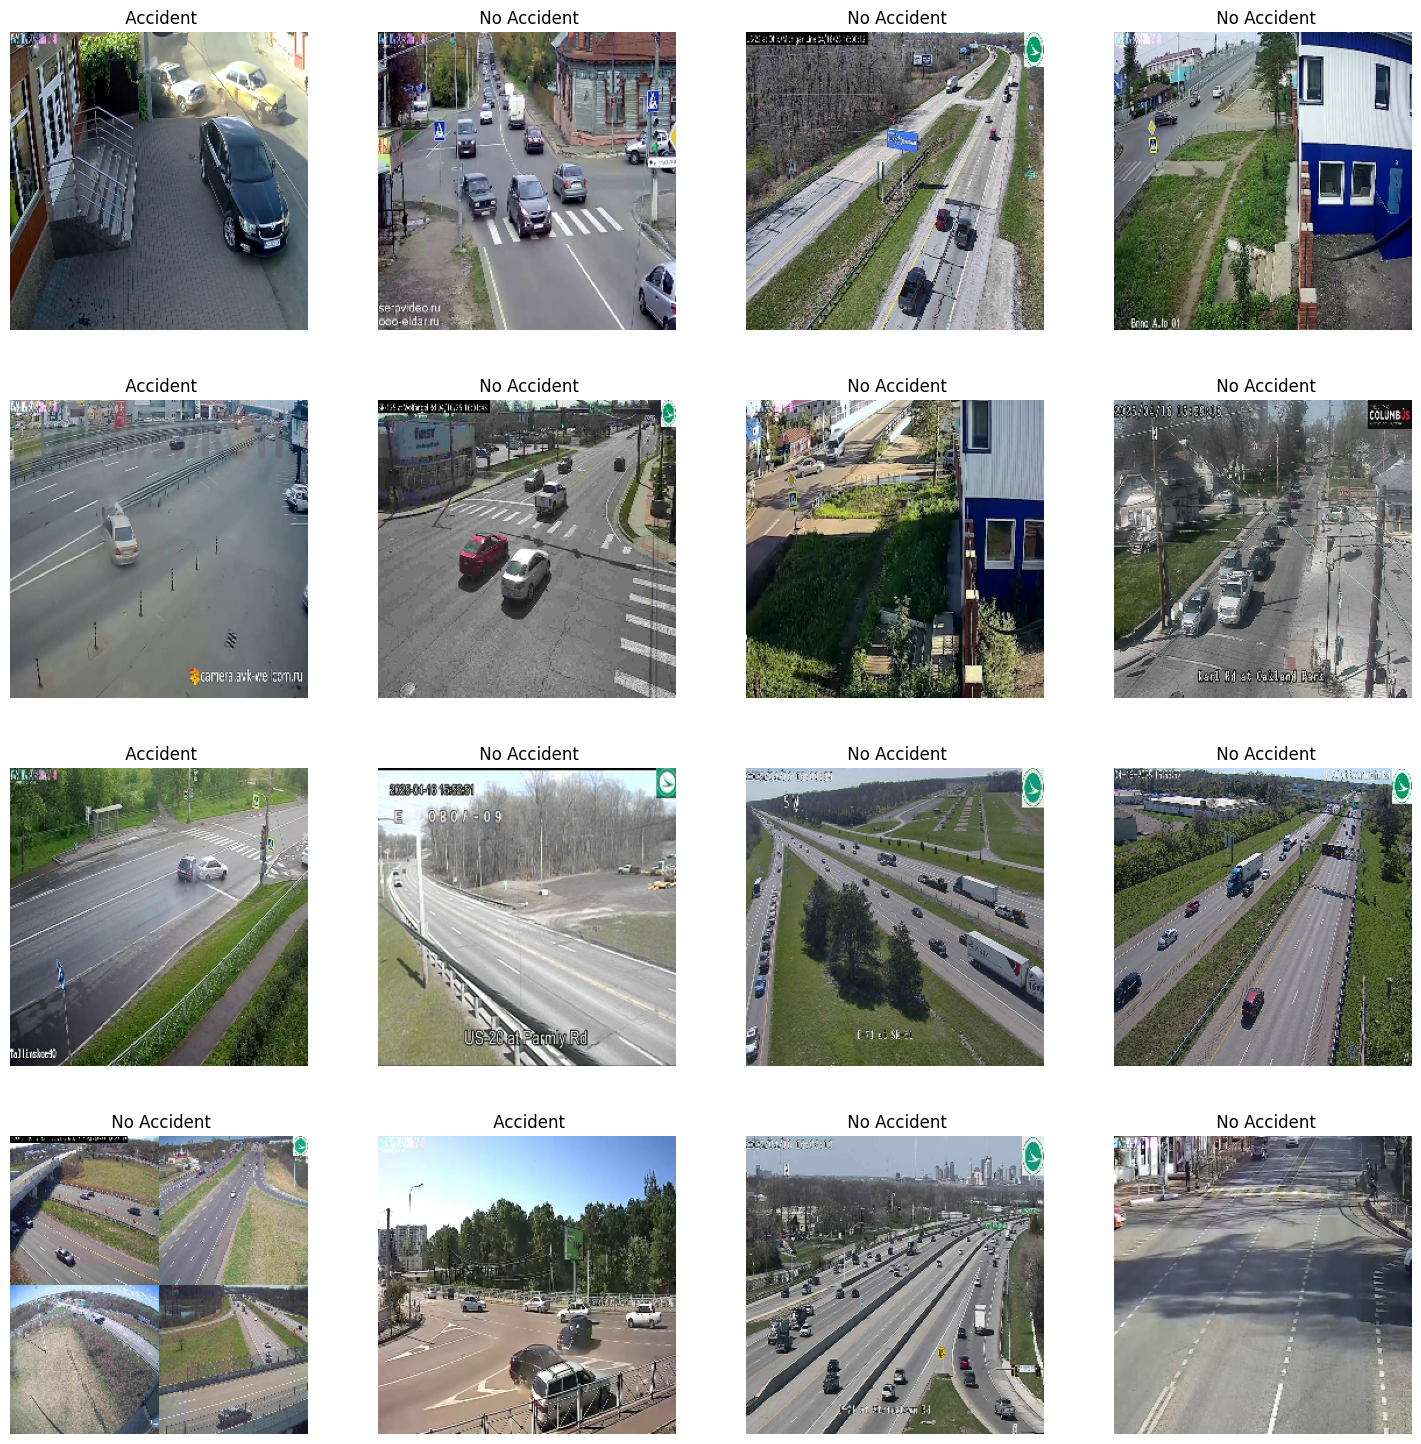

In [52]:

#lets see training data after normalization

cols = 4
rows = 4
fig, ax = plt.subplots(nrows= rows , ncols= cols,figsize=(15,15),layout='constrained')
fig.tight_layout(pad=2)




for outer_index, img in enumerate(tr_batch[0][:]):
    if outer_index >= rows*cols:
        break
        
    if (outer_index % cols == 0):
        for inner_index, img in enumerate(tr_batch[0][outer_index:outer_index+cols]):
    
        
            ax[outer_index//cols][inner_index].imshow(img)
            if(tr_batch[1][outer_index + inner_index] == 0):
               label = " Accident"
            else: label = " No Accident"
    
            
    
            
            ax[outer_index//cols][inner_index].set_aspect(1)

            num_label = tr_batch[1][outer_index + inner_index]
            
            ax[outer_index//cols][inner_index].axis("off")
            ax[outer_index//cols][inner_index].title.set_text(label)
            

plt.savefig("test.png")       
plt.show()



<h2>Loading Validation data for Hyper-parameter Turing</h2>

In [53]:
val_data_dir = os.path.join("./data/val")
val_data = tf.keras.utils.image_dataset_from_directory(val_data_dir)
val_data_iterator = val_data.as_numpy_iterator()
val_batch = val_data_iterator.next()

Found 248 files belonging to 2 classes.


In [54]:
# Normalizing Validation data
val_data = val_data.map(lambda x,y: (x/255, y))
val_batch = val_data.as_numpy_iterator().next()

<h1> 3. Building CNN Architecture  </h1>


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [56]:
model = Sequential()

In [57]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
# Adding neural Layer
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [58]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [59]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

<h1> 4.  Training Neural Network </h1>

In [60]:
# setting up for logging 
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [61]:
hist = model.fit(tr_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])
model.save("accidents-local.keras")                                                     

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.6541 - loss: 0.9173 - val_accuracy: 0.8347 - val_loss: 0.3991
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.7642 - loss: 0.4565 - val_accuracy: 0.8831 - val_loss: 0.2607
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.8180 - loss: 0.3470 - val_accuracy: 0.8992 - val_loss: 0.2202
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.8375 - loss: 0.3151 - val_accuracy: 0.9274 - val_loss: 0.1716
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.8496 - loss: 0.2983 - val_accuracy: 0.9073 - val_loss: 0.1875
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.8888 - loss: 0.2332 - val_accuracy: 0.9476 - val_loss: 0.1408
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9136 - loss: 0.2097 - val_accuracy: 0.9476 - val_loss: 0.1234
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - accuracy: 0.9094 - loss: 0.1799 - val_accuracy: 0

In [ ]:
#hist.history 

<h2>5.Seeing Training Loss and Accuracy Curve with epochs</h2>

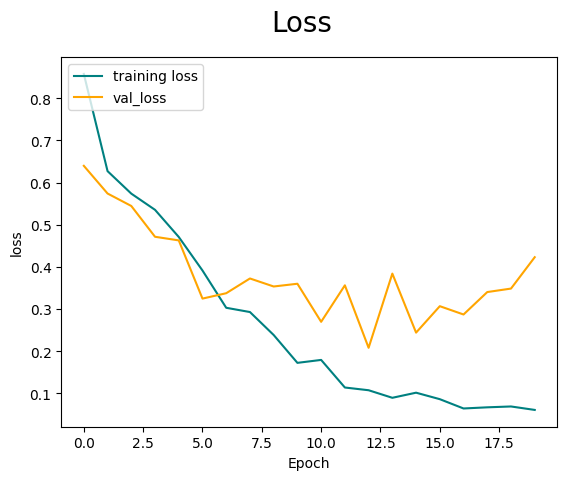

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='training loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.show()


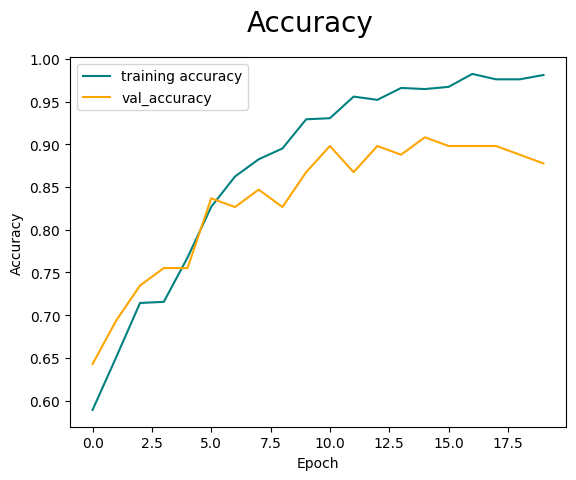

In [25]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='training accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()


<h1>6. Evaluation</h1>

In [26]:
test_data_dir = os.path.join("./data/test")
test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir)
test_data_iterator = test_data.as_numpy_iterator()
test_batch = test_data_iterator.next()

Found 100 files belonging to 2 classes.


In [27]:

pre = tf.keras.metrics.Precision
re = tf.keras.metrics.Recall()

In [28]:
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()

for batch in test_data:
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [29]:
def F1_score(precision, recall):
    return (2*precision*recall)/(precision+recall)

In [30]:
print("Model achieved an precision score of {:5f}".format(pre.result()))
print("Model achieved an recall score of {:5f}".format(re.result()))

Model achieved an precision score of 0.909091
Model achieved an recall score of 0.943396


In [31]:
f1_score = F1_score(pre.result(), re.result())
print("Model achieved an F1-score of {:5f}".format(f1_score))

Model achieved an F1-score of 0.925926


<h1> 7.Test just to see model working </h1>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


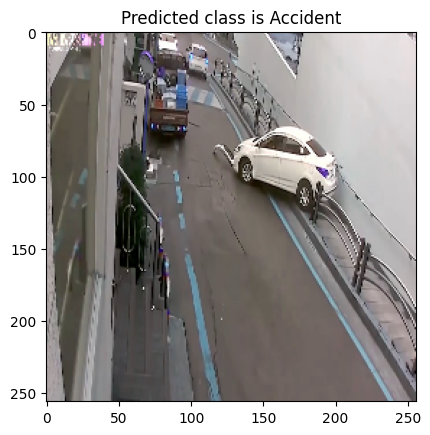

In [40]:
import cv2

# load random samples from samples directory
random_data_dirname = os.path.join("./data/test/Accident")
pics = [os.path.join(random_data_dirname, filename) for filename in os.listdir(random_data_dirname)]

# load first file from samples
sample = cv2.imread(pics[1], cv2.IMREAD_COLOR)
sample = cv2.resize(sample, (256, 256))

prediction = 1 - model.predict(np.expand_dims(sample/255, 0))

if prediction >= 0.5: 
    label = 'Predicted class is Accident'
else:
    label = 'Predicted class is Not Accident'

plt.title(label)
plt.imshow(sample)
plt.show()

### Create CSV Files for Submission

In [ ]:
import cv2
import pandas as pd

# load random samples from samples directory
test_data_dirname = os.path.join("./data/test")
pics = [os.path.join(test_data_dirname, filename) for filename in os.listdir(test_data_dirname)]


filenames = []
predictions = []

for dirname in os.listdir(test_data_dirname):
    for filename in os.listdir(os.path.join(test_data_dirname, dirname)):
        if not filename.endswith(".jpg"):
            continue
        filepath = os.path.join(test_data_dirname, dirname, filename)
        
        # load first file from samples
        sample = cv2.imread(filepath, cv2.IMREAD_COLOR)
        sample = cv2.resize(sample, (256, 256))
        
        # predict using model
        prediction = 1 - model.predict(np.expand_dims(sample/255, 0))
        # done because when we loaded data by default 0 label is given to first folder
        # which is Accident but we want just opposite labels
        # we want 0: Accident and 1: Not Accident
        
        filenames.append(filename)
        
        output = 1 if float(prediction[0][0]) >= 0.5 else 0
        predictions.append(output)

df = pd.DataFrame(columns=["ID", "Column ID"])
df["ID"] = filenames
df["Column ID"] = predictions
df.to_csv("/kaggle/working/submission.csv",index=False)